# Results

In [1]:
NAME = "Michael Cornelisse"
STUDENT_NUMBER = "s1059020"
COLLABORATOR_NAME = "Nienke Helmers"
COLLABORATOR_STUDENT_NUMBER = "s1016904"

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from graphviz import Source

from toolbox.pca_plot import get_variance_percentage, get_number_of_attributes,get_pca_data_sets, plot_pca_variance
from toolbox.data_processing import * 
from toolbox.k_fold_algorithm import k_fold, plot_classification_error
from toolbox.plot_results import get_tree_graph, plot_cm_and_rc
from toolbox.gradient_search import grid_search_classifier

from sklearn.decomposition import PCA
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_tree

In [3]:
patient_labels = ['ALL', 'AML']
X_train, X_test, y = load_data()

In [4]:
# Clean data
X_train, X_test, y = clean_data(X_train, X_test, y)
X_train, X_test = sort_X_train_and_test_data(X_train, X_test)
y.index = pd.to_numeric(y.index)
y_train, y_test = get_y_train_and_test_data(y)

In [5]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25
6,-138,-85,215,71,-272,-558,67,-186,87,193,...,115,1221,-76,172,-74,645,341,26,193,-53
7,-72,-144,238,55,-399,-551,131,-179,126,-20,...,30,819,-178,151,-18,1140,482,10,369,-42
8,-413,-260,7,-2,-541,-790,-275,-463,70,-169,...,289,629,-86,302,23,1799,446,59,781,20
9,5,-127,106,268,-210,-535,0,-174,24,506,...,356,980,6,177,-12,758,385,115,244,-39
10,-88,-105,42,219,-178,-246,328,-148,177,183,...,42,986,26,101,21,570,359,9,171,7


In [6]:
# Not sure if we need this
#X_train, y_test, X_test, y_test = reset_indexes(X_train, y_train, X_test, y_test)
y_train

,cancer
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [7]:
y_train['cancer'].value_counts() 

0    27
1    11
Name: cancer, dtype: int64

In [8]:
y_test['cancer'].value_counts()

0    20
1    14
Name: cancer, dtype: int64

In [9]:
y_np = y.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

In [10]:
pca = PCA()
pca_train = pca.fit_transform(X_train)
pca_test = pca.transform(X_test)

pca_complete = np.append(pca_train, pca_test, 0)
pca.n_components_

38

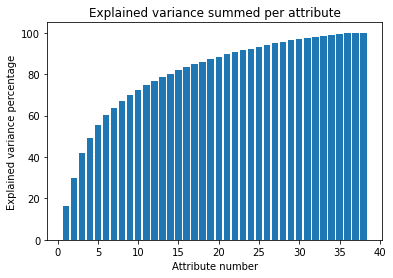

Figure: A plot of the explained variance. The variance is summed for all attributes up to and including
    the current attribute number,for examplethe tenth attribute shows the sum of attributes 1 to 10.
There are 21 attributes that together explain 90% of the variance.


In [11]:
pca_variance_percentage = get_variance_percentage(pca)
no_attributes = get_number_of_attributes(pca_variance_percentage)
plot_pca_variance(pca_variance_percentage, no_attributes)

In [12]:
#Crop pca_data
#pca_data = np.delete(pca_complete, slice(no_attributes, len(pca_complete)) , 1)

#Split data back to original train and test split
#pca_train = pca_data[:38]
#pca_test = pca_data[38:]

pca_data, pca_train, pca_test = get_pca_data_sets(pca_complete, no_attributes)

## Decision tree results

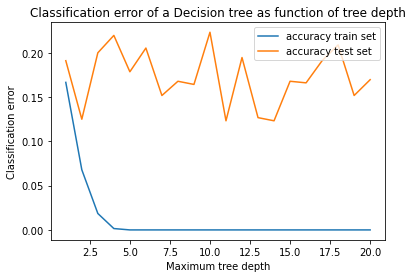

In [13]:
accuracy_mean_train_tree, accuracy_mean_test_tree = k_fold(pca_data, y_np, 10, 1, 21, 1, 'tree')
plot_classification_error(1, 21, 1, accuracy_mean_train_tree, accuracy_mean_test_tree, 'Decision', 'tree depth')

In [14]:
# Pure as a sanity check we run the grid search again. However, we do not display the full report only the best result.
parameters_tree = {
    'max_depth' : [2, 4, 6, 10, 'None'],
    'min_samples_leaf' : [2, 4, 6],
    'criterion' : ['gini', 'entropy'],
    'random_state' : ['None', 10, 42]
}

predictions_tree, dtc = grid_search_classifier('tree', parameters_tree, pca_train, pca_test, y_train, y_test)

The best parameters for this model are: 
DecisionTreeClassifier(max_depth=2, min_samples_leaf=2, random_state=10)
This gives an accuracy of 0.7941176470588235 and an error of 0.20588235294117652


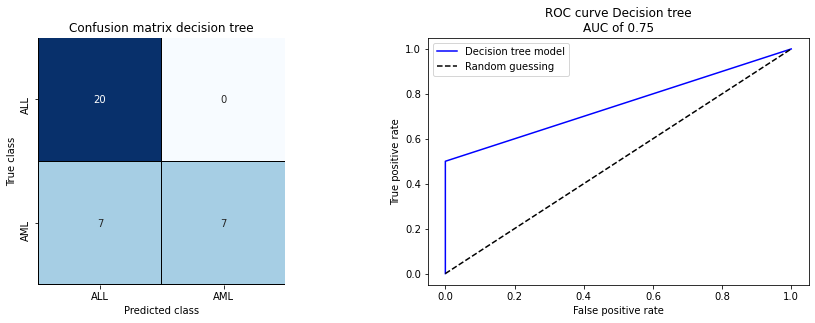

In [15]:
# Function for plotting the confusion matrices
conf_matrix_tree = metrics.confusion_matrix(y_test, predictions_tree)
plot_cm_and_rc(conf_matrix_tree, patient_labels,y_test, predictions_tree,'Decision tree', 'Confusion matrix decision tree')

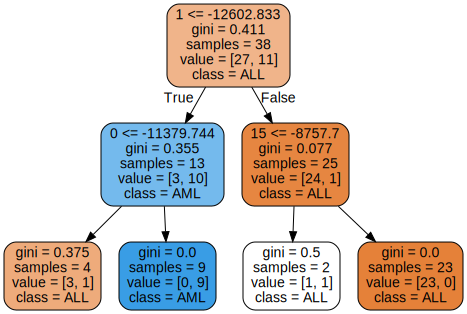

In [16]:
graph = get_tree_graph(dtc,0, no_attributes, patient_labels)
graph

## Random forest results

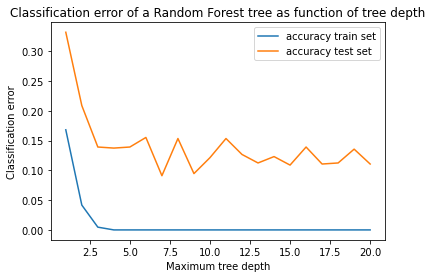

In [17]:
accuracy_mean_train_rf, accuracy_mean_test_rf = k_fold(pca_data, y_np.ravel(), 10, 1, 21, 1, 'rf')
plot_classification_error(1, 21, 1, accuracy_mean_train_rf, accuracy_mean_test_rf,'Random Forest', 'tree depth')

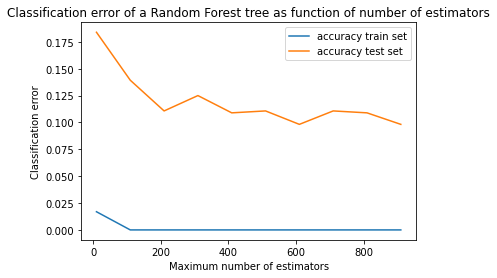

In [18]:
accuracy_mean_train_rf_est, accuracy_mean_test_rf_est = k_fold(pca_data, y_np.ravel(), 10, 10, 1001, 100, 'rf_estimators')
plot_classification_error(10, 1001, 100, accuracy_mean_train_rf_est, accuracy_mean_test_rf_est,'Random Forest', 'number of estimators')

In [19]:
parameters_rf = {
    'max_depth' : [2, 4, 6, 'None'],
    'n_estimators' : [250, 300, 350, 400],
    'min_samples_leaf' : [2, 4, 6],
    'criterion' : ['gini', 'entropy'],
    'random_state' : ['None', 10, 42]
}
predictions_rf, rf = grid_search_classifier('rf', parameters_rf, pca_train, pca_test, y_train_np.ravel(), y_test_np.ravel())


KeyboardInterrupt: 

In [ ]:
conf_matrix_rf = metrics.confusion_matrix(y_test, predictions_rf)
plot_cm_and_rc(conf_matrix_rf, patient_labels, y_test, predictions_rf,'Random forest', 'Confusion matrix random forest')

In [ ]:
estimator = rf.estimators_[100]
graph_rf = get_tree_graph(estimator, 0, no_attributes, patient_labels)
graph_rf

## Gradient boosting tree results

In [ ]:
accuracy_mean_train_xgb, accuracy_mean_test_xgb = k_fold(pca_data, y_np, 10, 1, 21, 1, 'xgb')
plot_classification_error(1, 21, 1, accuracy_mean_train_xgb, accuracy_mean_test_xgb,'XGB', 'tree depth')

In [ ]:
accuracy_mean_train_xgb_est, accuracy_mean_test_xgb_est =  k_fold(pca_data, y_np, 10, 10, 101, 10, 'xgb_estimators')
plot_classification_error(10, 101, 10, accuracy_mean_train_xgb_est, accuracy_mean_test_xgb_est,'XGB', 'number of estimators')

In [ ]:
parameters_xgb = {
    'max_depth' : [2, 4, 6, 'None'],
    'n_estimators' : [450, 500, 550, 600],
    'random_state' : ['None', 10, 42],
    'eval_metric': ['rmse','mape', 'auc' 'error'],
    'use_label_encoder' : ['False']
}

predictions_xgb, xb = grid_search_classifier('xgb', parameters_xgb, pca_train, pca_test, y_train_np.ravel(), y_test_np.ravel())

In [ ]:
conf_matrix_xgb = metrics.confusion_matrix(y_test, predictions_xgb)
plot_cm_and_rc(conf_matrix_xgb, patient_labels, y_test, predictions_xgb,'Gradient boost', 'Confusion matrix gradient boost')

In [ ]:
cd = {'shape': 'box',
 'style': 'filled,rounded',
 'fillcolor': '#78bceb'}

lf = {'shape': 'box',
 'style': 'filled, rounded',
 'fillcolor': '#e48038'}

xgb.to_graphviz(xb,condition_node_params = cd, leaf_node_params = lf, num_trees=2, feature_names= "test")